<code> 
<strong><font size="+3">COLLECTING ALL BLOB-LIKE EVENTS</font></strong>
In this Jupyter notebook, we collect all blob-like events from all ensemble members.
</code>

<code> Import packages </code>

In [2]:
import xarray as xr; import numpy as np; import pandas as pd
import netCDF4 as nc; import scipy
import matplotlib.pyplot as plt
import cmocean
from sklearn import preprocessing # will use MinMaxScaler from sklearn

<code> Area of interest </code>

In [3]:
# latitude and longitude range for the North Pacific Ocean
lon_lim_less = 0.; lon_lim_great = 67.5 # x
lat_lim_less = 20.; lat_lim_great = 60. # y

# rescale
x_list = np.array([-180, lon_lim_less, lon_lim_great, 180]).reshape(-1,1)
x_scaler = preprocessing.MinMaxScaler(feature_range=(0, 287))
x_normalizedlist=x_scaler.fit_transform(x_list)

y_list = np.array([-90, lat_lim_less, lat_lim_great, 90]).reshape(-1,1)
y_scaler = preprocessing.MinMaxScaler(feature_range=(0, 191))
y_normalizedlist=y_scaler.fit_transform(y_list)

In [4]:
f_row = int(np.round(y_normalizedlist[1].item()))
l_row = int(np.round(y_normalizedlist[2].item()))

f_col = int(np.round(x_normalizedlist[1].item()))
l_col = int(np.round(x_normalizedlist[2].item()))

In [5]:
print(f_row)
print(l_row)

print(f_col)
print(l_col)

117
159
144
197


In [6]:
f_row_small = int(np.round(y_normalizedlist[1].item()))
l_row_small = int(np.round(y_normalizedlist[2].item()))

f_col_small = (x_normalizedlist[1].item()+((x_normalizedlist[2].item()-x_normalizedlist[1].item())/2))
l_col_small = int(np.round(x_normalizedlist[2].item()))

In [7]:
print(f_row_small)
print(l_row_small)

print(f_col_small)
print(l_col_small)

117
159
170.40625
197


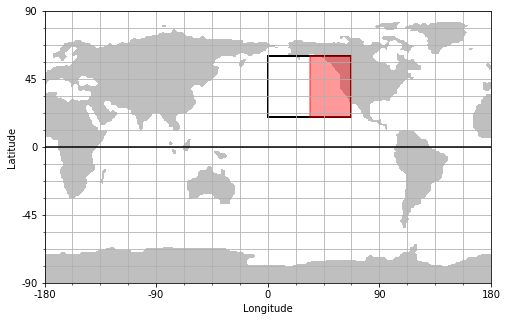

In [8]:
from matplotlib import patches # for the purpose of plotting

NPO_patch = patches.Rectangle((x_normalizedlist[1].item(), y_normalizedlist[1].item()), x_normalizedlist[2].item()-x_normalizedlist[1].item(), y_normalizedlist[2].item()-y_normalizedlist[1].item(), linewidth=2, edgecolor='k', facecolor='none',alpha=1.) 
NPO_smaller_patch_rotated = patches.Rectangle((x_normalizedlist[1].item()+((x_normalizedlist[2].item()-x_normalizedlist[1].item())/2), y_normalizedlist[1].item()), (x_normalizedlist[2].item()-x_normalizedlist[1].item())/2, y_normalizedlist[2].item()-y_normalizedlist[1].item(), linewidth=2, edgecolor='red', facecolor='red',alpha=.4) 

# landmask with relabeled axes
land_mask = np.load('SST_land.npy')
land_mask[land_mask > 0] = np.nan

fig, ax = plt.subplots(figsize=(8,5))
ax.contourf(land_mask, cmap='binary')
ax.minorticks_on()
ax.axhline(y=95.5, c='k', linestyle='-') # this is the equator line
ax.set_xticks([0, 71.75, 143.5, 215.25, 287]);ax.set_xticklabels([-180, -90, 0, 90, 180])
ax.set_yticks([0, 47.75, 95.5, 143.25, 191]);ax.set_yticklabels([-90, -45, 0, 45, 90])
ax.set_xlabel('Longitude'); ax.set_ylabel('Latitude')
ax.grid(which='both')
ax.add_patch(NPO_patch)
ax.add_patch(NPO_smaller_patch_rotated)

plt.show()

<code> Collecting all blob-like events </code>

In [18]:
%%time
# Note: This takes about 33 minutes to run 10 ensemble members. For 100 ensemble members, it will take around 5.5 hours.

kept_heatwaves_all = []
for ens_memb in range(90,100):
    filename = '/glade/work/cassiacai/member{}_events.nc'.format(ens_memb)
    member_ = xr.open_dataset(filename)
    ending_val = len(np.unique(member_.labels))
    
    # kept_heatwaves = []
    for i in range(1,ending_val):
        mhw_id = i
        mhw_event_rel = member_.where(member_.labels==mhw_id, drop=False)
        x = mhw_event_rel.SSTA[:,:,:]
        no_nans_x = np.nan_to_num(x)
        no_nans_x[no_nans_x != 0] = 1
        
        sum_of_one = no_nans_x.sum(axis=(0))
        event_len = np.nanmax(sum_of_one)
        
        if np.sum(sum_of_one[f_row:l_row,f_col:l_col]) > 0 and np.nanmax(sum_of_one) > 2: 
            array_of_interest = np.copy(sum_of_one[f_row:l_row,f_col:l_col])
            array_of_interest[array_of_interest != 0] = 1
            if np.nansum(array_of_interest) / (42*53*0.01) >= 25: 
                mhw_event_sel = member_.where(member_.labels==i, drop=False)
                # kept_heatwaves.append(mhw_event_sel)
                kept_heatwaves_all.append(mhw_event_sel)

CPU times: user 19min, sys: 15min 41s, total: 34min 41s
Wall time: 35min 23s


In [19]:
concated_kept_heatwaves_xarray = xr.concat(kept_heatwaves_all, "heatwave_label")

In [20]:
concated_kept_heatwaves_xarray

<xarray.Dataset>
Dimensions:    (heatwave_label: 122, time: 481, lat: 192, lon: 288)
Coordinates:
  * time       (time) object 1975-01-01 00:00:00 ... 2015-01-01 00:00:00
  * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
    member_id  (heatwave_label) <U12 'r11i1301p1f2' ... 'r20i1301p1f2'
    quantile   float64 0.9
    month      (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 3 4 5 6 7 8 9 10 11 12 1
Dimensions without coordinates: heatwave_label
Data variables:
    labels     (heatwave_label, time, lat, lon) float64 nan nan nan ... nan nan
    SSTA       (heatwave_label, time, lat, lon) float64 nan nan nan ... nan nan

In [21]:
# concated_kept_heatwaves_xarray.to_netcdf('/glade/work/cassiacai/member0_9_bloblike_events_new_stuff.nc')
# concated_kept_heatwaves_xarray.to_netcdf('/glade/work/cassiacai/member10_19_bloblike_events_new_stuff.nc')
# concated_kept_heatwaves_xarray.to_netcdf('/glade/work/cassiacai/member20_29_bloblike_events_new_stuff.nc')
# concated_kept_heatwaves_xarray.to_netcdf('/glade/work/cassiacai/member30_39_bloblike_events_new_stuff.nc')
# concated_kept_heatwaves_xarray.to_netcdf('/glade/work/cassiacai/member40_49_bloblike_events_new_stuff.nc')
# concated_kept_heatwaves_xarray.to_netcdf('/glade/work/cassiacai/member50_59_bloblike_events_new_stuff.nc')
# concated_kept_heatwaves_xarray.to_netcdf('/glade/work/cassiacai/member60_69_bloblike_events_new_stuff.nc')
# concated_kept_heatwaves_xarray.to_netcdf('/glade/work/cassiacai/member70_79_bloblike_events_new_stuff_.nc')
# concated_kept_heatwaves_xarray.to_netcdf('/glade/work/cassiacai/member80_89_bloblike_events_new_stuff_.nc')
concated_kept_heatwaves_xarray.to_netcdf('/glade/work/cassiacai/member90_99_bloblike_events_new_stuff_.nc')

# concated_kept_heatwaves_xarray.to_netcdf('/glade/work/cassiacai/member10_19_bloblike_events.nc')
# concated_kept_heatwaves_xarray.to_netcdf('/glade/work/cassiacai/member20_29_bloblike_events.nc')
# concated_kept_heatwaves_xarray.to_netcdf('/glade/work/cassiacai/member30_39_bloblike_events.nc')
# concated_kept_heatwaves_xarray.to_netcdf('/glade/work/cassiacai/member40_49_bloblike_events.nc')

<code> 
<strong><font size="+3">COMPARING ALL BLOB-LIKE EVENTS</font></strong>
</code>

In [22]:
filename1 = '/glade/work/cassiacai/member0_9_bloblike_events_new_stuff.nc' # 118 heatwave events
filename2 = '/glade/work/cassiacai/member10_19_bloblike_events_new_stuff.nc' # 99 heatwave events
filename3 = '/glade/work/cassiacai/member20_29_bloblike_events_new_stuff.nc' # 121 heatwave events
filename4 = '/glade/work/cassiacai/member30_39_bloblike_events_new_stuff.nc' # 116 heatwave events
filename5 = '/glade/work/cassiacai/member40_49_bloblike_events_new_stuff.nc' # 116 heatwave events
filename6 = '/glade/work/cassiacai/member50_59_bloblike_events_new_stuff.nc' # 123 heatwave events
filename7 = '/glade/work/cassiacai/member60_69_bloblike_events_new_stuff.nc' # 112 heatwave events
filename8 = '/glade/work/cassiacai/member70_79_bloblike_events_new_stuff_.nc' # 105 heatwave events
filename9 = '/glade/work/cassiacai/member80_89_bloblike_events_new_stuff_.nc' # 99 heatwave events
# Maybe there is something wrong here? Why are there only 12 heatwave events total in ensembles 90 to 99?
filename10 = '/glade/work/cassiacai/member90_99_bloblike_events_new_stuff_.nc' # 12 heatwave events

In [23]:
# let's work with the first 10 ensemble members
blob_like_file = xr.open_dataset(filename10)
blob_like_file

<xarray.Dataset>
Dimensions:    (heatwave_label: 122, time: 481, lat: 192, lon: 288)
Coordinates:
  * time       (time) object 1975-01-01 00:00:00 ... 2015-01-01 00:00:00
  * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
    member_id  (heatwave_label) object ...
    quantile   float64 ...
    month      (time) int64 ...
Dimensions without coordinates: heatwave_label
Data variables:
    labels     (heatwave_label, time, lat, lon) float64 ...
    SSTA       (heatwave_label, time, lat, lon) float64 ...

Clustering is a processof grouping data with similar spatial attributes, temporal attributes, or both, from which many significant events and regular phenomena can be discovered. 

In [11]:
# collecting our lists
cumulative_SSTA = [] # adding up SSTAs
area_filled_of_region_with_days = [] 
area_filled_of_region_wo_days = []
length_of_event = []

for i in range((np.shape(np.asarray(blob_like_file.SSTA))[0])):
    x = blob_like_file.SSTA[i,:,:,:]

    # cumulative SSTA (summing SSTAs across all days)
    cumulative_SSTA.append(x.sum(axis=(0)))

    # collecting events that fill up X percentage of our area of interest
    no_nans_x = np.nan_to_num(x)
    no_nans_x[no_nans_x != 0] = 1
    sum_of_one = no_nans_x.sum(axis=(0))
    array_of_interest = np.copy(sum_of_one[f_row:l_row,f_col:l_col])

    area_filled_of_region_with_days.append(np.nansum(array_of_interest) / (42*53*0.01))
    length_of_event.append(np.nanmax(array_of_interest))
    array_of_interest[array_of_interest != 0] = 1
    area_filled_of_region_wo_days.append(np.nansum(array_of_interest) / (42*53*0.01))    

In [12]:
import seaborn as sns

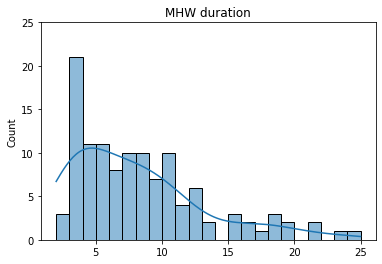

The longest event lasts 25.0 months or 2.08 years.
The shortest collected event lasts 2.0 months or 0.17 years.


In [42]:
sns.histplot(data=length_of_event, binwidth=1, kde=True)
plt.ylim(0, 25)
plt.title('MHW duration')
plt.show()

print('The longest event lasts', np.nanmax(length_of_event), 'months or', np.around(np.nanmax(length_of_event)/12, decimals=2), 'years.') 
print('The shortest collected event lasts', np.nanmin(length_of_event), 'months or', np.around(np.nanmin(length_of_event)/12, decimals=2), 'years.') 

In [11]:
print(len(cumulative_SSTA))
print(len(area_filled_of_region_with_days))
print(len(area_filled_of_region_wo_days))
print(len(length_of_event))

118
118
118
118


In [12]:
X = np.reshape(np.asarray(cumulative_SSTA), (118, 192*288))
print(X.shape)

(118, 55296)


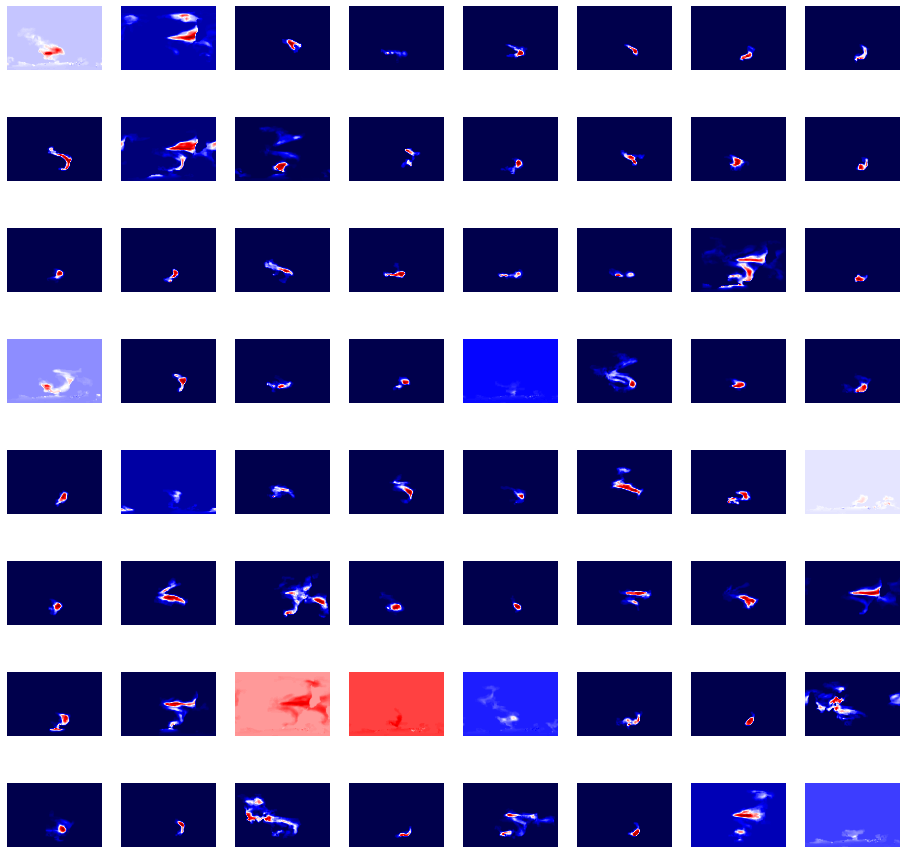

In [13]:
def plot_grid(XX, N):  
    """Small helper function to plot"""
    fig, ax = plt.subplots(N, N, figsize=(16, 16))
    for i in range(N):
        for j in range(N):
            ax[i,j].imshow(XX[(N)*i+j,:].reshape((192, 288)), cmap="seismic")
            ax[i,j].axis("off")
plot_grid(X, 8)

In [14]:
# using sklearn

# --- 
# Pointer: sklearn has functionalities for PCA and Ridge regression with crossvalidation. 
# Using these can make your life much easier.
# --- 

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [15]:
mean_data = np.mean(X,0)
centered_X = X - mean_data

pca = PCA(n_components = 100)
pca.fit(centered_X) #X_train_standard

components = pca.components_
print(components[:16,:].shape)

(16, 55296)


In [16]:
#### Explained variance, explained variance ratio, singular values
# -------------------------------------------
# From documentation:

# explained_variance_ : array, shape (n_components,) The amount 
# of variance explained by each of the selected components.

# explained_variance_ratio_ : array, shape (n_components,) Percentage 
# of variance explained by each of the selected components.

# singular_values_ndarray of shape (n_components,)
# The singular values corresponding to each of the selected components. 
# The singular values are equal to the 2-norms of the n_components 
# variables in the lower-dimensional space.

# -------------------------------------------

nuclear_norm = np.linalg.norm(pca.singular_values_) # is the sum of singular singulars
sv_scaled = pca.singular_values_**2/(nuclear_norm**2) 
# sv_scaled = pca.explained_variance_ratio_
sv_total = np.cumsum(pca.singular_values_**2)/(nuclear_norm**2)

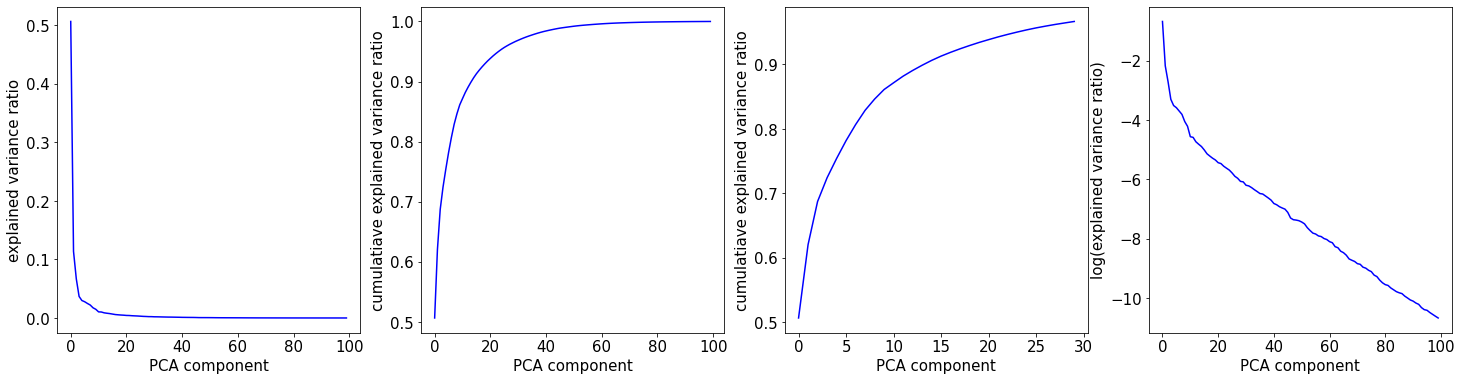

In [17]:
# -- Plot the singular values
plt.rcParams["figure.figsize"] = (25,6)

plt.subplot(1, 4, 1)
plt.plot(sv_scaled, 'blue') # equivalent to pca.explained_variance_ratio_
plt.xticks(fontsize=15); plt.yticks(fontsize=15)
plt.xlabel('PCA component', fontsize=15)
plt.ylabel('explained variance ratio', fontsize=15)

plt.subplot(1, 4, 2)
plt.plot(sv_total, 'blue')
plt.xticks(fontsize=15); plt.yticks(fontsize=15)

plt.xlabel('PCA component', fontsize=15)
plt.ylabel('cumulatiave explained variance ratio', fontsize=15)

plt.subplot(1, 4, 3)
plt.plot(sv_total[:30], 'blue')
plt.xticks(fontsize=15); plt.yticks(fontsize=15)

plt.xlabel('PCA component', fontsize=15)
plt.ylabel('cumulatiave explained variance ratio', fontsize=15)

plt.subplot(1, 4, 4)
plt.plot(np.log(sv_scaled),'blue') # equivalent to np.log(pca.singular_values_)
# plt.plot(np.log(pca.singular_values_))
plt.xticks(fontsize=15); plt.yticks(fontsize=15)
plt.xlabel('PCA component', fontsize=15)
plt.ylabel('log(explained variance ratio)', fontsize=15)

plt.show()

In [18]:
pca_total = PCA(n_components=100)
pca_total.fit(X)
frobenius_norm = np.sqrt(sum(pca_total.singular_values_**2))

In [19]:
def no_pca_modes(ratio):
    pca_test = PCA(n_components=1)
    pca_test.fit(X)
    np.sqrt(sum(pca_test.singular_values_**2))
    i = 1
    while np.sqrt(sum(pca_test.singular_values_**2)) < ratio*frobenius_norm:
        i += 1
        pca_test = PCA(n_components=i)
        pca_test.fit(X)
    return i

print('Number of PCA modes to keep to approximate X_train up to 60%: ', no_pca_modes(0.6))
print('Number of PCA modes to keep to approximate X_train up to 80%: ',no_pca_modes(0.8))
print('Number of PCA modes to keep to approximate X_train up to 90%: ',no_pca_modes(0.9))
print('Number of PCA modes to keep to approximate X_train up to 95%: ',no_pca_modes(0.95))

Number of PCA modes to keep to approximate X_train up to 60%:  1
Number of PCA modes to keep to approximate X_train up to 80%:  3
Number of PCA modes to keep to approximate X_train up to 90%:  8
Number of PCA modes to keep to approximate X_train up to 95%:  15


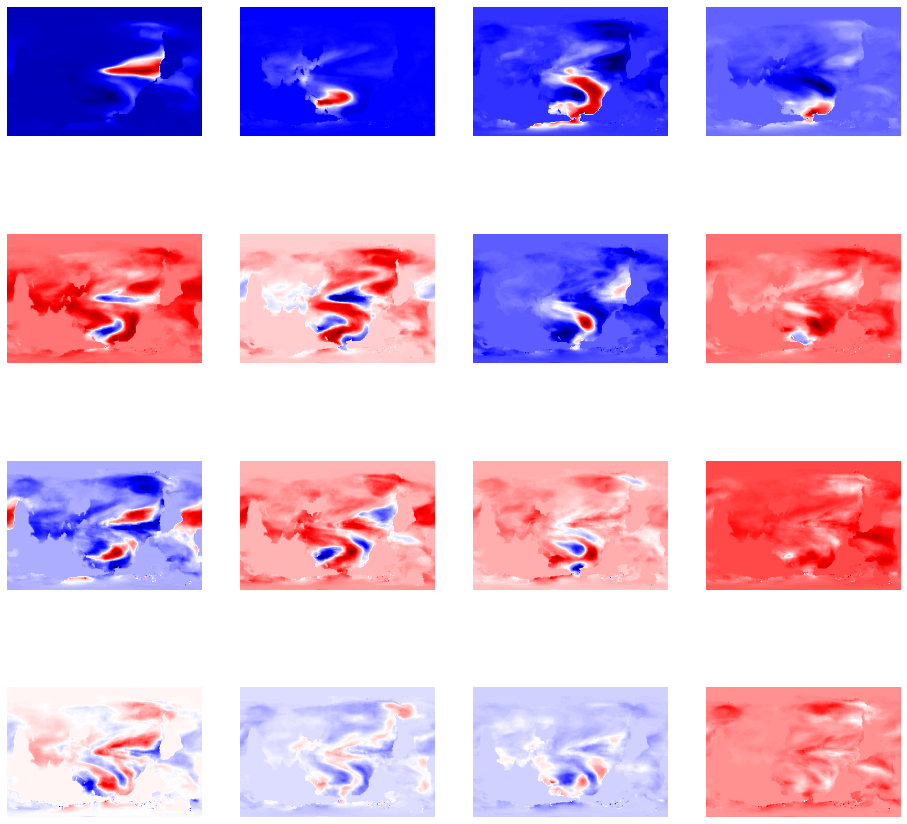

In [20]:
plot_grid(components[:16,:], 4)

(100, 192, 288)


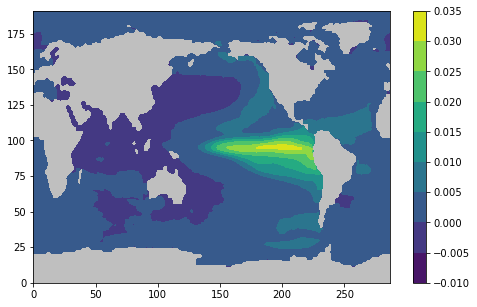

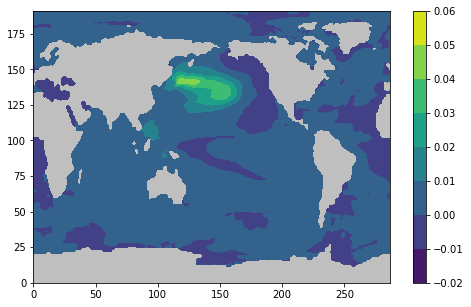

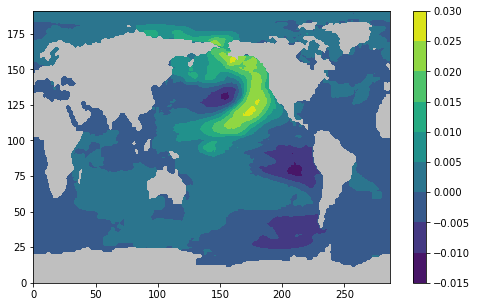

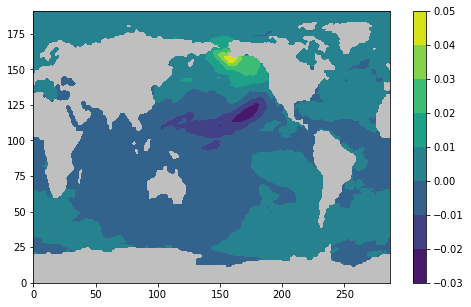

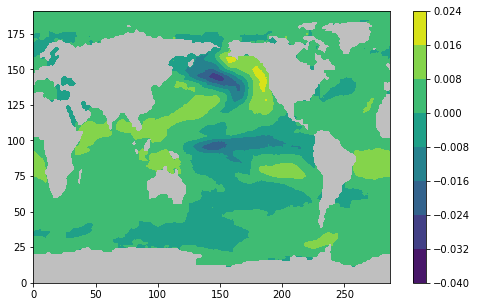

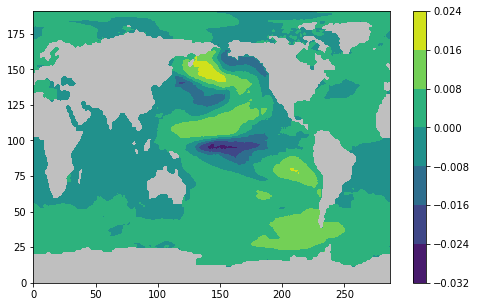

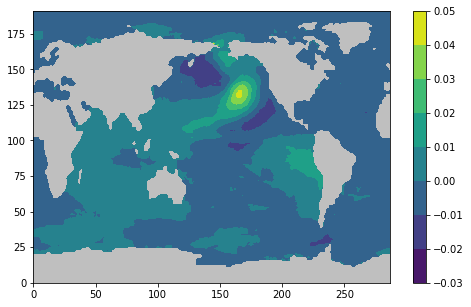

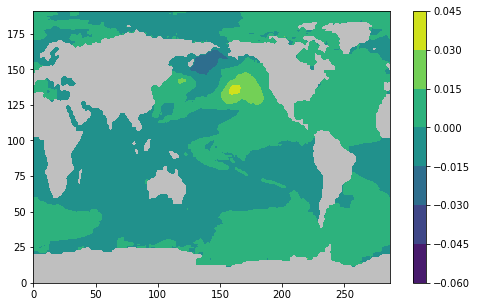

In [53]:
reshape_comp = np.reshape(components, (100,192,288))
print(reshape_comp.shape)
reshape_comp[0,:,:].shape

fig, ax = plt.subplots(figsize=(8,5))
plt.contourf(reshape_comp[0,:,:])
plt.colorbar()
plt.contourf(land_mask, cmap='binary')
plt.show()

fig, ax = plt.subplots(figsize=(8,5))
plt.contourf(reshape_comp[1,:,:])
plt.colorbar()
plt.contourf(land_mask, cmap='binary')
plt.show()

fig, ax = plt.subplots(figsize=(8,5))
plt.contourf(reshape_comp[2,:,:])
plt.colorbar()
plt.contourf(land_mask, cmap='binary')
plt.show()

fig, ax = plt.subplots(figsize=(8,5))
plt.contourf(reshape_comp[3,:,:])
plt.colorbar()
plt.contourf(land_mask, cmap='binary')
plt.show()

fig, ax = plt.subplots(figsize=(8,5))
plt.contourf(reshape_comp[4,:,:])
plt.colorbar()
plt.contourf(land_mask, cmap='binary')
plt.show()

fig, ax = plt.subplots(figsize=(8,5))
plt.contourf(reshape_comp[5,:,:])
plt.colorbar()
plt.contourf(land_mask, cmap='binary')
plt.show()

fig, ax = plt.subplots(figsize=(8,5))
plt.contourf(reshape_comp[6,:,:])
plt.colorbar()
plt.contourf(land_mask, cmap='binary')
plt.show()

fig, ax = plt.subplots(figsize=(8,5))
plt.contourf(reshape_comp[7,:,:])
plt.colorbar()
plt.contourf(land_mask, cmap='binary')
plt.show()

We only need the first 3 PCA components to approximate 80% of X.

In [54]:
PCs = pca.transform(X)
PCs.shape

(118, 100)

In [59]:
number_of_PCA_modes = 8

In [60]:
print(PCs[:,0:number_of_PCA_modes].shape)

(118, 8)


In [62]:
# Let's just check what this looks like. Note to self: This is basically EOFs. 
print(PCs[0,:8]) 
print(PCs[1,:8])
print(PCs[2,:8])
print(PCs[3,:8])

[-31.93888766 602.62727648  32.53232967  77.25929957 -18.86514233
 -19.13756881   8.85688917  86.63718097]
[ 946.94843569   92.07971686 -303.90629855   69.40997015  -15.98744787
  174.55201213   82.08418427   74.05551312]
[ 12.89601673  -0.9845718   34.90097279 -25.04645061   5.24761111
   8.29870808 -10.62492952  16.26650325]
[ -5.81444557 131.68322792  24.61693266  49.7454304  -24.5971831
   2.2771122   -3.11643995  39.79574352]


In [63]:
from sklearn import decomposition

grid = X
n_samples, n_features = grid.shape
estimator_3 = decomposition.PCA(n_components=3)
grid_recons_3 = estimator_3.inverse_transform(estimator_3.fit_transform(grid))

In [64]:
indices = np.random.choice(n_samples, 5, replace=False)

In [65]:
image_shape = (192, 288)

In [66]:
n_components = 8

Show 5 randomly chosen grids and their PCA reconstructions with 8 dominant eigenvectors

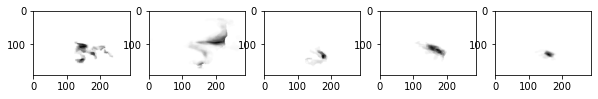

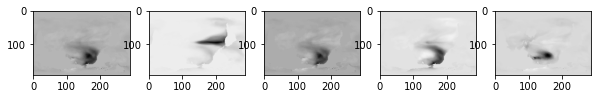

In [67]:
plt.figure(figsize=(10,5))
for i in range(len(indices)):
    plt.subplot(1,5,i+1), plt.imshow(np.reshape(grid[indices[i],:], image_shape), cmap="Greys"), plt.axis('on')
plt.show()

plt.figure(figsize=(10,5))
for i in range(len(indices)):
    plt.subplot(1,5,i+1), plt.imshow(np.reshape(grid_recons_3[indices[i],:], image_shape),cmap="Greys"), plt.axis('on')
plt.show()

In [68]:
from sklearn.cluster import KMeans

kmeans = KMeans(init="random",
                n_clusters=6, # elbow plot
                n_init=10,
                max_iter=300,
                random_state=42)

In [69]:
kmeans.fit(PCs)

KMeans(init='random', n_clusters=6, random_state=42)

In [72]:
# The lowest SSE value --> What does this mean? Algorithm is trying to minimize this.
kmeans.inertia_

11358519.998038173

In [73]:
# Final locations of the centroid
kmeans.cluster_centers_

array([[ 1.28764013e+03,  3.11687916e+02,  4.49536185e+02,
         6.77993949e+01, -1.20804542e+01,  1.06487004e+02,
         1.81693944e+01,  2.12429964e+02, -4.31632131e+01,
        -7.32691377e+00,  8.54021193e+01,  1.16449519e+02,
         2.51527157e+01,  2.69572109e+01, -6.71067405e+01,
         4.21306043e+01, -1.43011423e+01, -8.60534867e+01,
         2.89691522e+01,  7.54095549e+00, -1.72379384e+01,
        -2.57053812e+01, -2.31927792e+01,  1.01436856e+01,
        -5.17746533e+00,  7.36480723e+00,  3.45445777e+00,
         1.04196472e+01,  1.11254542e-01, -1.75526312e+01,
         5.16620690e+00, -9.75146882e+00, -7.50358147e+00,
        -7.71743258e+00, -7.91043889e+00,  2.49342183e+00,
         1.09697681e+01, -7.49074138e-01, -8.54997877e+00,
         1.66861050e+00, -3.94558236e+00, -5.55866074e+00,
         1.37722076e+01,  7.46208364e+00,  8.16483770e-01,
         5.26479739e+00,  1.82450933e+00,  2.28382426e-01,
        -4.82797318e+00, -3.25108543e+00,  5.53488081e+0

In [74]:
# The number of iterations required to converge
kmeans.n_iter_

5

In [75]:
kmeans.labels_

array([4, 5, 2, 2, 2, 2, 2, 2, 2, 5, 4, 2, 2, 2, 4, 2, 2, 2, 2, 2, 2, 2,
       0, 2, 3, 2, 2, 2, 2, 2, 4, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 4,
       2, 2, 2, 5, 3, 1, 5, 2, 4, 2, 2, 2, 3, 2, 2, 2, 1, 2, 1, 2, 2, 2,
       1, 1, 5, 4, 4, 3, 2, 2, 1, 2, 2, 5, 2, 2, 5, 3, 2, 2, 4, 2, 2, 2,
       2, 2, 2, 2, 5, 3, 5, 2, 2, 2, 4, 2, 2, 2, 2, 4, 2, 3, 2, 2, 2, 2,
       2, 2, 4, 0, 2, 5, 4, 5], dtype=int32)

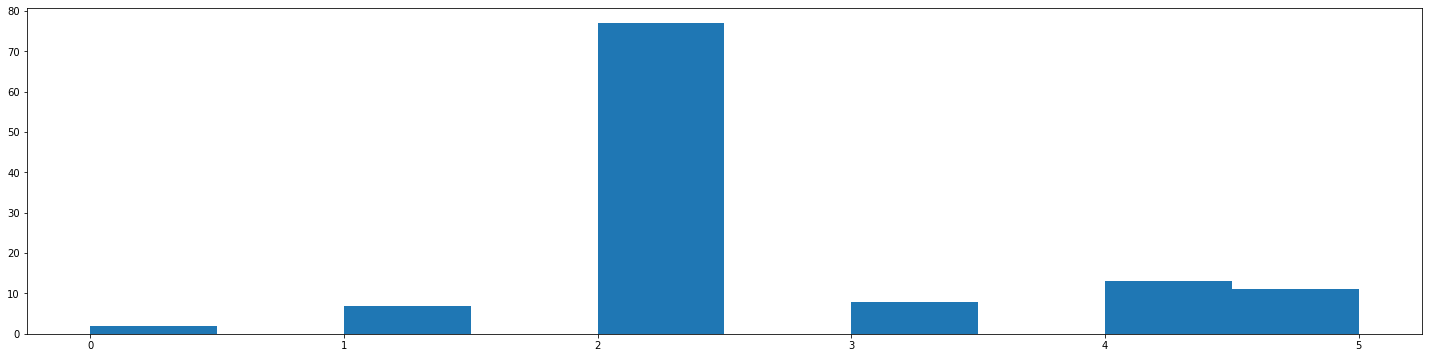

In [77]:
plt.hist(kmeans.labels_)
plt.show()

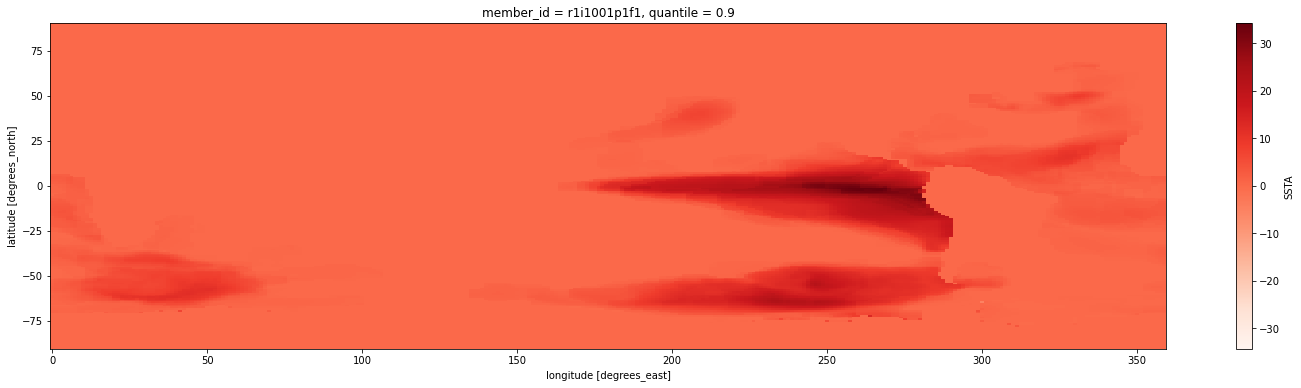

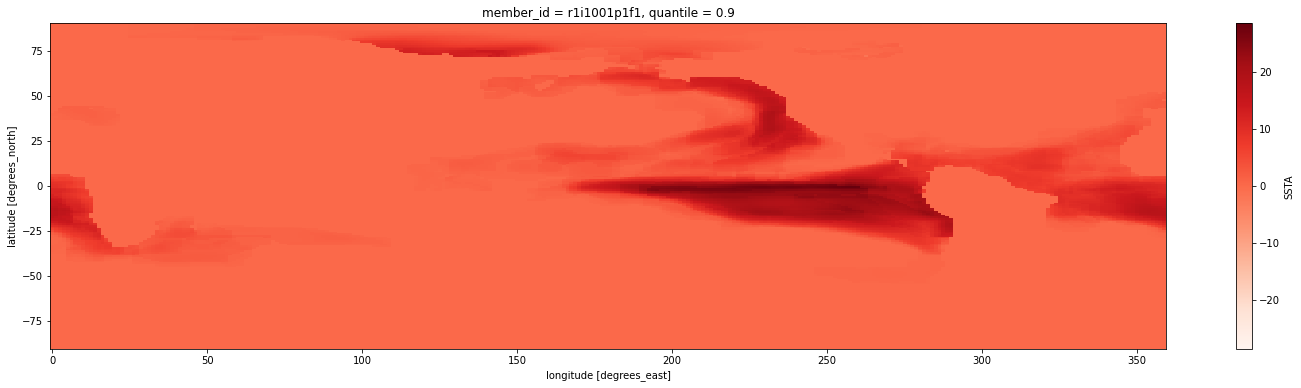

In [78]:
blob_like_file.SSTA[1,:,:,:].sum(axis=0).plot(cmap='Reds')
plt.show()
blob_like_file.SSTA[9,:,:,:].sum(axis=0).plot(cmap='Reds')
plt.show()

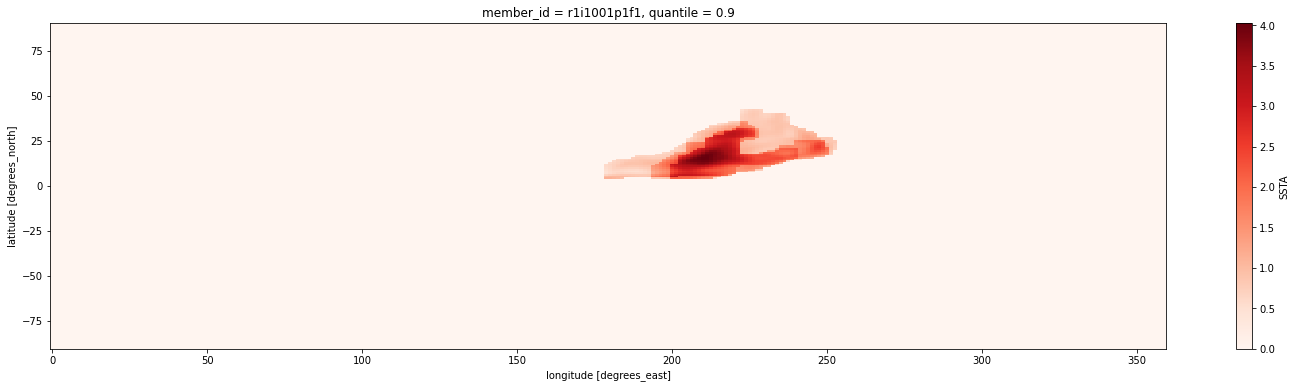

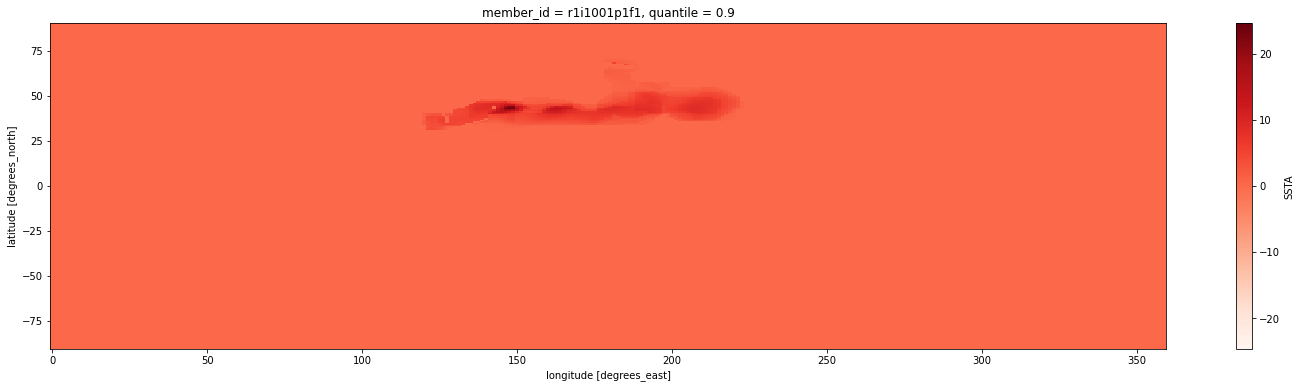

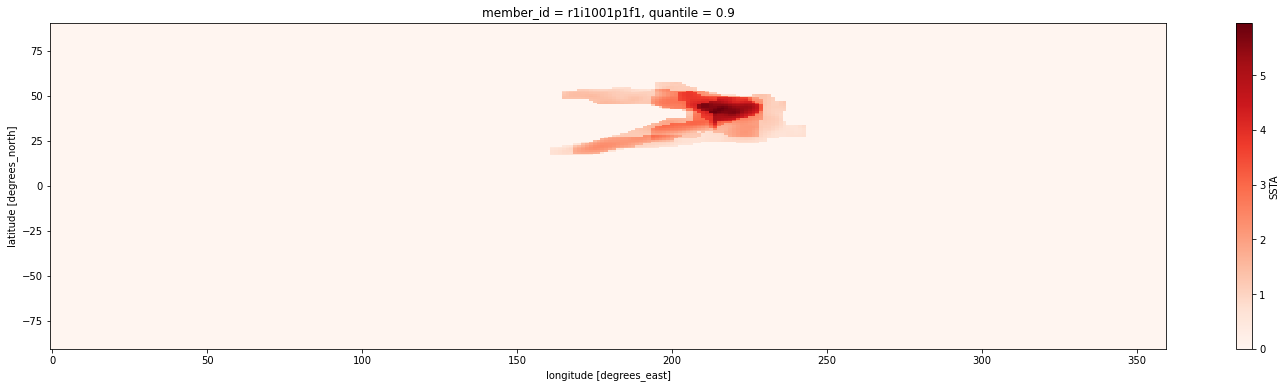

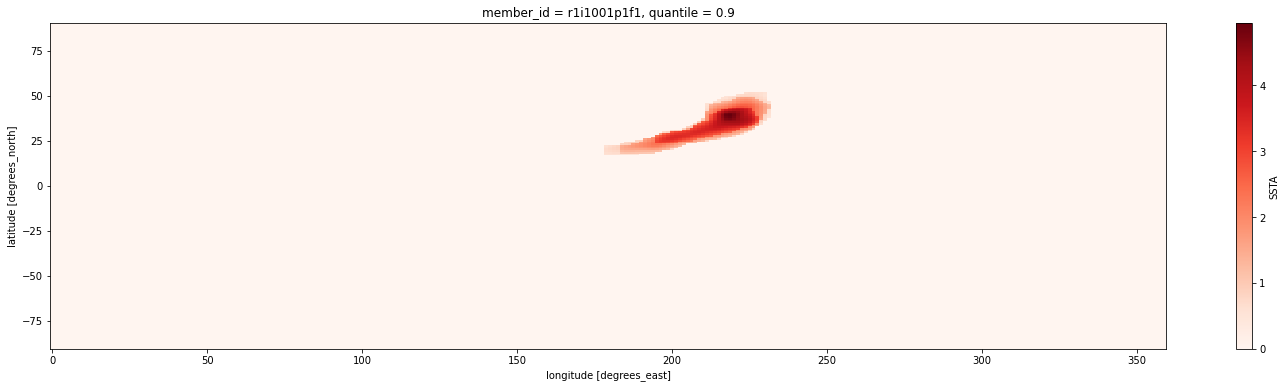

In [79]:
blob_like_file.SSTA[2,:,:,:].sum(axis=0).plot(cmap='Reds')
plt.show()
blob_like_file.SSTA[3,:,:,:].sum(axis=0).plot(cmap='Reds')
plt.show()
blob_like_file.SSTA[4,:,:,:].sum(axis=0).plot(cmap='Reds')
plt.show()
blob_like_file.SSTA[5,:,:,:].sum(axis=0).plot(cmap='Reds')
plt.show()

In [ ]:
# Visualize as a widget (timeseries) *code is up on Github
# ----- save slices, stitch as a GIF --> visualize and see

# Patterns of evolution (look the same in space but different in time) --> acted differently maybe


In [ ]:
# variance --> build --> sum, variance, moments --> can start describing the distribution --> skewness
# maybe make feature --> distances


In [ ]:
# --> how you sample --> 2 cluster within 2 groups --> some popular thing --> hides the details of the other groups
# --> clustering on the other stuff

In [68]:
# We should be able to something with PCs. 

In [71]:
# TO DO: Statistics of lots of stuff. What will the paper look like? What do we want to include in the paper? 
# And Hillary's paper???? And mine?????

In [ ]:
# ~~~~~~~~~~~~~~ Alternative method ~~~~~~~~~~~~~~
# try hierarchical clustering --> level of connection between hard to differentiate clusters --> don't have 
# to decide the number of clusters until later --> link --> scikit-learn --> dendogram

<code> 
<strong><font size="+3">SCRATCH WORK BELOW</font></strong>
</code>

- What do events that have an ENSO footprint look like? How many are there? What is their footprint in the North Pacific look like?

In [ ]:
mhw_label = 11

blob_like_file.SSTA[mhw_label,:,:,:].sum(axis=0).plot(cmap='Reds')
plt.show()
print(np.nanmean(blob_like_file.SSTA[mhw_label,:,:,:].sum(axis=0)))
print(np.nanmax(blob_like_file.SSTA[mhw_label,:,:,:].sum(axis=0)))
print(np.nanmin(blob_like_file.SSTA[mhw_label,:,:,:].sum(axis=0)))

In [ ]:
mhw_label = 5

NPO_patch = patches.Rectangle((x_normalizedlist[1].item(), y_normalizedlist[1].item()), x_normalizedlist[2].item()-x_normalizedlist[1].item(), y_normalizedlist[2].item()-y_normalizedlist[1].item(), linewidth=2, edgecolor='k', facecolor='none',alpha=1.) 
NPO_smaller_patch_rotated = patches.Rectangle((x_normalizedlist[1].item()+((x_normalizedlist[2].item()-x_normalizedlist[1].item())/2), y_normalizedlist[1].item()), (x_normalizedlist[2].item()-x_normalizedlist[1].item())/2, y_normalizedlist[2].item()-y_normalizedlist[1].item(), linewidth=2, edgecolor='red', facecolor='red',alpha=.4)

fig, ax = plt.subplots(figsize=(8,5))
im = ax.contourf(blob_like_file.SSTA[mhw_label,:,:,:].sum(axis=(0)), cmap = 'seismic')

fig.colorbar(im, orientation='vertical')

ax.contourf(land_mask, cmap='binary')
ax.minorticks_on()
ax.axhline(y=95.5, c='k', linestyle='-') # this is the equator line
ax.set_xticks([0, 71.75, 143.5, 215.25, 287]);ax.set_xticklabels([-180, -90, 0, 90, 180])
ax.set_yticks([0, 47.75, 95.5, 143.25, 191]);ax.set_yticklabels([-90, -45, 0, 45, 90])
ax.set_xlabel('Longitude'); ax.set_ylabel('Latitude')
ax.grid(which='both')
ax.add_patch(NPO_patch)
ax.add_patch(NPO_smaller_patch_rotated)

plt.show()

In [ ]:
print(np.nanmax(blob_like_file.SSTA[mhw_label,:,:,:].sum(axis=(0))))
print(np.nanmin(blob_like_file.SSTA[mhw_label,:,:,:].sum(axis=(0))))

In [ ]:
print(np.nanmax(area_filled_of_region_wo_days))
print(np.nanmin(area_filled_of_region_wo_days))

In [ ]:
print(len(length_of_event))
print(np.nanmax(length_of_event))
print(np.nanmean(length_of_event))
print(np.nanmin(length_of_event))

In [ ]:
plt.hist(length_of_event,bins=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25], rwidth=0.8)
plt.xlabel('length of event in months')
plt.ylabel('frequency')
plt.grid()
plt.xticks([2,4,6,8,10,12,14,16,18,20,22,24,26])
plt.yticks([2,4,6,8,10,12,14,16,18,20,22])
plt.show()

In [ ]:
statement = np.argwhere((np.asarray(length_of_event) >= 2) & (np.asarray(area_filled_of_region_wo_days) > 25))
print(len(statement))

In [ ]:
x = blob_like_file.SSTA[9,:,:,:]
x_summed_SSTA = x.sum(axis=(0))
no_nans_x = np.nan_to_num(x)
no_nans_x[no_nans_x != 0] = 1
sum_of_one = no_nans_x.sum(axis=(0))

In [ ]:
plt.contourf(sum_of_one)

In [ ]:
x_summed_SSTA = x.sum(axis=(0))
np.nanmax(x_summed_SSTA)
np.nanmin(x_summed_SSTA)

In [ ]:
from matplotlib import patches # for the purpose of plotting

NPO_patch = patches.Rectangle((x_normalizedlist[1].item(), y_normalizedlist[1].item()), x_normalizedlist[2].item()-x_normalizedlist[1].item(), y_normalizedlist[2].item()-y_normalizedlist[1].item(), linewidth=2, edgecolor='k', facecolor='none',alpha=1.) 

# landmask with relabeled axes
land_mask = np.load('SST_land.npy')
land_mask[land_mask > 0] = np.nan

fig, ax = plt.subplots(figsize=(10,5))
contourf_  = ax.contourf(sum_of_one, cmap=cmocean.cm.matter,levels=[2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20])
cbar = fig.colorbar(contourf_)
cbar.set_label('# of months', rotation=270,labelpad=15)

ax.contourf(land_mask, cmap='binary')
ax.minorticks_on()
ax.axhline(y=95.5, c='k', linestyle='-') # this is the equator line
ax.set_xticks([0, 71.75, 143.5, 215.25, 287]);ax.set_xticklabels([-180, -90, 0, 90, 180])
ax.set_yticks([0, 47.75, 95.5, 143.25, 191]);ax.set_yticklabels([-90, -45, 0, 45, 90])
ax.set_xlabel('Longitude'); ax.set_ylabel('Latitude')
ax.grid(which='both')
ax.add_patch(NPO_patch)
plt.show()

In [ ]:
np.nanmax(x_summed_SSTA)

In [ ]:
from matplotlib import patches # for the purpose of plotting

NPO_patch = patches.Rectangle((x_normalizedlist[1].item(), y_normalizedlist[1].item()), x_normalizedlist[2].item()-x_normalizedlist[1].item(), y_normalizedlist[2].item()-y_normalizedlist[1].item(), linewidth=2, edgecolor='k', facecolor='none',alpha=1.) 

# landmask with relabeled axes
land_mask = np.load('SST_land.npy')
land_mask[land_mask > 0] = np.nan

fig, ax = plt.subplots(figsize=(10,5))
contourf_  = ax.contourf(x_summed_SSTA, cmap=cmocean.cm.matter,levels=[0,2,4,6,8,10,12,14,16,18,20,22,24,26,28,30,32])
cbar = fig.colorbar(contourf_)
cbar.set_label('Cumulative SSTA', rotation=270,labelpad=15)

ax.contourf(land_mask, cmap='binary')
ax.minorticks_on()
ax.axhline(y=95.5, c='k', linestyle='-') # this is the equator line
ax.set_xticks([0, 71.75, 143.5, 215.25, 287]);ax.set_xticklabels([-180, -90, 0, 90, 180])
ax.set_yticks([0, 47.75, 95.5, 143.25, 191]);ax.set_yticklabels([-90, -45, 0, 45, 90])
ax.set_xlabel('Longitude'); ax.set_ylabel('Latitude')
ax.grid(which='both')
ax.add_patch(NPO_patch)
plt.show()

In [ ]:
for i in range(len(statement)):
    event_label = statement[i][0]
    print(i)
    x = blob_like_file.SSTA[event_label,:,:,:]
    x_summed_SSTA = x.sum(axis=(0))
    no_nans_x = np.nan_to_num(x)
    no_nans_x[no_nans_x != 0] = 1

    sum_of_one = no_nans_x.sum(axis=(0))
    array_of_interest = np.copy(sum_of_one[f_row:l_row,f_col:l_col])
    print(np.nansum(array_of_interest) / (42*53*0.01))
    print(np.nanmax(array_of_interest))
    array_of_interest[array_of_interest != 0] = 1
    print(np.nansum(array_of_interest) / (42*53*0.01))

    NPO_patch = patches.Rectangle((x_normalizedlist[1].item(), y_normalizedlist[1].item()), x_normalizedlist[2].item()-x_normalizedlist[1].item(), y_normalizedlist[2].item()-y_normalizedlist[1].item(), linewidth=2, edgecolor='red', facecolor='none',alpha=1.) 

    fig, ax = plt.subplots(figsize=(8,5))
    ax.contourf(sum_of_one)
    ax.contourf(land_mask, cmap='binary')
    ax.minorticks_on()
    ax.axhline(y=95.5, c='k', linestyle='-') # this is the equator line
    ax.set_xticks([0, 71.75, 143.5, 215.25, 287]);ax.set_xticklabels([-180, -90, 0, 90, 180])
    ax.set_yticks([0, 47.75, 95.5, 143.25, 191]);ax.set_yticklabels([-90, -45, 0, 45, 90])
    ax.set_xlabel('Longitude'); ax.set_ylabel('Latitude')
    ax.grid(which='both')
    ax.add_patch(NPO_patch)
    plt.show()

#     fig, ax = plt.subplots(figsize=(8,5))
#     ax.contourf(x_summed_SSTA, cmap='Reds')
#     ax.contourf(land_mask, cmap='binary')
#     ax.minorticks_on()
#     ax.axhline(y=95.5, c='k', linestyle='-') # this is the equator line
#     ax.set_xticks([0, 71.75, 143.5, 215.25, 287]);ax.set_xticklabels([-180, -90, 0, 90, 180])
#     ax.set_yticks([0, 47.75, 95.5, 143.25, 191]);ax.set_yticklabels([-90, -45, 0, 45, 90])
#     ax.set_xlabel('Longitude'); ax.set_ylabel('Latitude')
#     ax.grid(which='both')
#     plt.show()

In [ ]:
# for i in range(5):
#     x = blob_like_file.SSTA[i,:,:,:]
#     x_summed_SSTA = x.sum(axis=(0))
#     no_nans_x = np.nan_to_num(x)
#     no_nans_x[no_nans_x != 0] = 1

#     sum_of_one = no_nans_x.sum(axis=(0))
#     array_of_interest = np.copy(sum_of_one[f_row:l_row,f_col:l_col])
#     print(np.nansum(array_of_interest) / (42*53*0.01))
#     print(np.nanmax(array_of_interest))
#     array_of_interest[array_of_interest != 0] = 1
#     print(np.nansum(array_of_interest) / (42*53*0.01))

#     NPO_patch = patches.Rectangle((x_normalizedlist[1].item(), y_normalizedlist[1].item()), x_normalizedlist[2].item()-x_normalizedlist[1].item(), y_normalizedlist[2].item()-y_normalizedlist[1].item(), linewidth=2, edgecolor='k', facecolor='none',alpha=1.) 

#     fig, ax = plt.subplots(figsize=(8,5))
#     ax.contourf(sum_of_one)
#     ax.contourf(land_mask, cmap='binary')
#     ax.minorticks_on()
#     ax.axhline(y=95.5, c='k', linestyle='-') # this is the equator line
#     ax.set_xticks([0, 71.75, 143.5, 215.25, 287]);ax.set_xticklabels([-180, -90, 0, 90, 180])
#     ax.set_yticks([0, 47.75, 95.5, 143.25, 191]);ax.set_yticklabels([-90, -45, 0, 45, 90])
#     ax.set_xlabel('Longitude'); ax.set_ylabel('Latitude')
#     ax.grid(which='both')
#     ax.add_patch(NPO_patch)
#     plt.show()

#     fig, ax = plt.subplots(figsize=(8,5))
#     ax.contourf(x_summed_SSTA, cmap='Reds')
#     ax.contourf(land_mask, cmap='binary')
#     ax.minorticks_on()
#     ax.axhline(y=95.5, c='k', linestyle='-') # this is the equator line
#     ax.set_xticks([0, 71.75, 143.5, 215.25, 287]);ax.set_xticklabels([-180, -90, 0, 90, 180])
#     ax.set_yticks([0, 47.75, 95.5, 143.25, 191]);ax.set_yticklabels([-90, -45, 0, 45, 90])
#     ax.set_xlabel('Longitude'); ax.set_ylabel('Latitude')
#     ax.grid(which='both')
#     plt.show()

In [ ]:
if np.sum(sum_of_one[f_row:l_row,f_col:l_col]) > 0 and np.nanmax(sum_of_one) > 2: 
            array_of_interest = np.copy(sum_of_one[f_row:l_row,f_col:l_col])
            array_of_interest[array_of_interest != 0] = 1
            if np.nansum(array_of_interest) / (42*53*0.01) >= 25: 

In [ ]:
event_lengths = []
for i in range(118):
    x = blob_like_file.SSTA[i,:,:,:]
    no_nans_x = np.nan_to_num(x)
    no_nans_x[no_nans_x != 0] = 1

    sum_of_one = no_nans_x.sum(axis=(0))
    print(np.shape(sum_of_one))
    event_lengths.append(np.nanmax(sum_of_one))

In [ ]:
print(np.argwhere(np.asarray(event_lengths)>20))

In [ ]:
from matplotlib import patches # for the purpose of plotting

# NPO_patch = patches.Rectangle((x_normalizedlist[1].item(), y_normalizedlist[1].item()), x_normalizedlist[2].item()-x_normalizedlist[1].item(), y_normalizedlist[2].item()-y_normalizedlist[1].item(), linewidth=2, edgecolor='k', facecolor='none',alpha=1.) 

# landmask with relabeled axes
land_mask = np.load('SST_land.npy')
land_mask[land_mask > 0] = np.nan

fig, ax = plt.subplots(figsize=(8,5))
ax.contourf(blob_like_file.SSTA[112,:,:,:].sum(axis=(0)))
ax.contourf(land_mask, cmap='binary')
ax.minorticks_on()
ax.axhline(y=95.5, c='k', linestyle='-') # this is the equator line
ax.set_xticks([0, 71.75, 143.5, 215.25, 287]);ax.set_xticklabels([-180, -90, 0, 90, 180])
ax.set_yticks([0, 47.75, 95.5, 143.25, 191]);ax.set_yticklabels([-90, -45, 0, 45, 90])
ax.set_xlabel('Longitude'); ax.set_ylabel('Latitude')
ax.grid(which='both')
# ax.add_patch(NPO_patch)
plt.show()

In [ ]:
fig, axs = plt.subplots(3,5, figsize=(22, 12), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .3, wspace=.1)
axs = axs.ravel()

for i in range(len(kept_indices)):
    NPO_patch = patches.Rectangle((x_normalizedlist[1].item(), y_normalizedlist[1].item()), x_normalizedlist[2].item()-x_normalizedlist[1].item(), y_normalizedlist[2].item()-y_normalizedlist[1].item(), linewidth=1, edgecolor='white', facecolor='none',alpha=1) 

    axs[i].contourf(full__analysis_arrays[kept_indices[i]])
    axs[i].contourf(land_mask,cmap='binary_r',vmin=0)
    axs[i].minorticks_on()
    axs[i].axhline(y=95.5, c='white', linestyle='-') # this is the equator line
    axs[i].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    axs[i].tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
    axs[i].add_patch(NPO_patch)

In [ ]:
plt.hist(event_lengths,bins=[0,2,4,6,8,10,12,14,16,18,20,22,24,26])
plt.show()